# TP3: Generative Models in Pytorch

**Authors:** 
- julien.denize@centralesupelec.fr
- tom.dupuis@centralesupelec.fr


If you have questions or suggestions, contact us and we will gladly answer and take into account your remarks.

For this tp you need to have some ground understanding of pytorch and basics introduction. It is available [here](https://pytorch.org/tutorials/beginner/basics/intro.html).




## Objective

In this TP, we will implement Generative Adversarial Networks (GANs) to generate new images based on the [MNIST dataset](http://yann.lecun.com/exdb/mnist/).

As a bonus, we will also implement a Variational Auto Encoder (VAE) to compare results from both methods.

The MNIST database of handwritten digits has a training set of 60 000 examples, and a test set of 10 000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. 


## Your task

Fill the missing parts in the code (parts between # --- START CODE HERE and # --- END CODE HERE)

## Retrieve MNIST dataset

### Load the dataset

Before diving into GANs and training our model, we need to load the data.

As said before we will use the MNIST dataset for training (and not testing as we don't need it). We will first load the data using the torchvision [MNIST dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html).

We will apply the transform to convert to tensor the images.

In [ ]:
# --- START CODE HERE (01)
# Import dataset and transforms
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
# --- END CODE HERE

# --- START CODE HERE (02)
# Instantiate the dataset.
transform = ToTensor()

dataset_train = MNIST(".", train=True, transform=transform, download=True)
# --- END CODE HERE

### Visualization

We provide below the functions to visualize data and metrics. We also provide a function to initialize our networks later.

You can toy with the functions to visualize the different parts of the dataset and later to display generated images.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import torch
import torchvision
from matplotlib import rc
from torchvision.utils import make_grid
from torch import Tensor
from typing import List

rc('animation', html='jshtml')


# We define here an util function to initialize the weights of our network.
# This function is not related to visualization.
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    m.weight.data.normal_(0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    m.weight.data.normal_(1.0, 0.02)
    m.bias.data.fill_(0)


def display_losses_and_accuracies_gan(discriminator_loss, generator_loss, real_accuracy, fake_accuracy):
  """
  Display the losses and accuracies from our GAN model.

  Args:
    discriminator_loss: the discriminator loss list.
    generator_loss: the generator loss list.
    real_accuracy: the real accuracy from our discriminator list.
    fake_accuracy: the fake accuracy from our discriminator list.
  """
  plt.figure(figsize=(10,4))
  plt.subplot(1,2,1)
  plt.plot(discriminator_loss, 'r', label='discriminator')
  plt.plot(generator_loss, 'g--', label='generator')
  plt.xlabel('# epoch')
  plt.ylabel('loss')
  plt.grid(True)
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(real_accuracy, 'r', label='real')
  plt.plot(fake_accuracy, 'g--', label='fake')
  plt.xlabel('# epoch')
  plt.ylabel('accuracy')
  plt.grid(True)
  plt.legend()
  plt.show()


def display_losses_and_accuracies_vae(kl_loss, recon_loss):
  """
  Display the losses from our VAE model.

  Args:
    kl_loss: the kl loss list.
    recon_loss: the reconstruction loss list.
  """
  plt.figure(figsize=(10,4))
  plt.subplot(1,2,1)
  plt.plot(kl_loss, 'r', label='kl loss')
  plt.xlabel('# epoch')
  plt.ylabel('loss')
  plt.grid(True)
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(recon_loss, 'g--', label='reconstruction loss')
  plt.xlabel('# epoch')
  plt.ylabel('loss')
  plt.grid(True)
  plt.legend()
  plt.show()


def compute_accuracy(preds: Tensor, y: Tensor) -> Tensor:
  """
  Compute the accuracy.
  
  Args
    preds: predicted value by the discriminator.
    y: ground-truth class to predict.
  Returns:
    The accuracy.
  """
  
  hard_preds = (preds > 0.5).long().float()
  return torch.mean((hard_preds == y).long().float())


def denormalize_tensor(tensor, mean, std) -> Tensor:
  """
  Denormalize a tensor.

  Args:
    tensor: the tensor to denormalize.
    mean: the mean that normalized.
    std: the std that normalized.
  Return:
    The denormalized tensor.
  """
  
  mean = torch.tensor(mean).view((1, 1, 1, 1))
  std = torch.tensor(std).view((1, 1, 1 , 1))
  return tensor * std + mean


def show(imgs) -> None:
  """
  Show input images.

  Args:
    imgs: the images to show
  """
  
  if not isinstance(imgs, list):
      imgs = [imgs]
  fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(8,8))
  plt.axis('off')
  for i, img in enumerate(imgs):
      img = img.detach()
      img = torchvision.transforms.functional.to_pil_image(img)
      axs[0, i].imshow(255 - np.asarray(img), cmap='gray_r')
      axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


def display_tensors_in_grid(tensors, nrows=5, padding=10) -> None:
  """
  Convert tensors images into grid and display the grid.

  Args:
    tensors: The tensors images to display.
    nrows: The number of rows in the grid.
    padding: The padding pixels added around each image.
  """

  grid = make_grid(tensors, nrow=nrows, padding=padding)
  show(grid)


def display_fake_images_in_grid(list_tensors, nrows=5, padding=10):
  """
  Convert tensors images into grid and display the grid.

  Args:
    list_tensors: The tensors images to display.
    nrows: The number of rows in the grid.
    padding: The padding pixels added around each image.
  """

  for tensor in list_tensors:
    grid = make_grid((tensor * 255), nrow=nrows, padding=padding)
    show(grid)


def get_slide_show_fake_images_in_grid(fake_images: List[Tensor], every_n_grid: int = 10) -> animation.ArtistAnimation:
  """
  Get the animation to display given fake images as grids.

  Args:
    fake_images: the list of images to display.
    every_n_grid: show grids modulo this parameter to prevent animation RAM error.

  Return:
    the slide show of fake images in grid.
  """

  kept_fake_images = [fake_image for i,fake_image in enumerate(fake_images) if i % (every_n_grid - 1) == 0]
  cat_fake_images = torch.stack([make_grid(fake_image, nrow=5, padding=10).permute(1,2,0) for fake_image in kept_fake_images])
  cat_fake_images = 255 - (cat_fake_images * 255).cpu().long()
  fig, ax = plt.subplots(figsize=(8,8))
  frames = [[ax.imshow(cat_fake_images[i], cmap="gray")] for i in range(len(cat_fake_images))]
  ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
  anim = animation.ArtistAnimation(fig,frames)
  plt.close()
  return anim

Grid of train images:


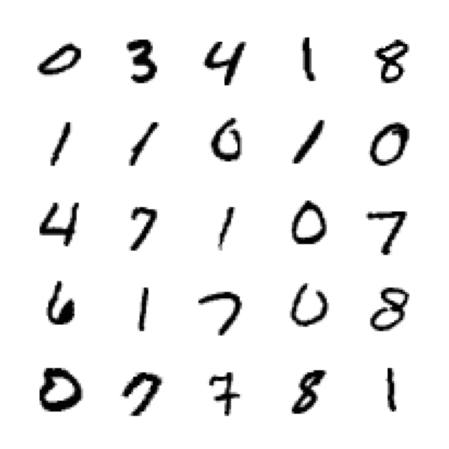

In [ ]:
random_train_samples = [dataset_train[idx] for idx in np.random.choice(len(dataset_train), 25)]
random_train_X = torch.stack([sample[0] for sample in random_train_samples])
train_grid = display_tensors_in_grid(random_train_X)

print(f"Grid of train images:")

## Generative Adversarial Network (GAN)



### Introduction

GANs have been first proposed in 2014 by [Ian Goodfellow et al](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf). 

They consist of two neural networks that learn adversarial tasks.
- The **Generator** (G) learns to generate data.
- The **Discriminator** (D) learns to distinguish between fake data generated by the generator and real data.

Our objective will be to generate new figure images for MNIST thanks to the Generator network of a GAN.

![](https://files.realpython.com/media/fig_generative.5f01c08f5208.png)

To generate new data, generative models generally takes as an input a random vector drawn from a specific distribution and the generator outputs accordingly to this distribution an image.

To train a GAN, the generator and the discriminator are trained at different steps. There could be several steps for updating the generator before updating the discriminator.  To simply training we will perform the training of the whole GAN by doing for each iteration:
- 1 step of Generator update
- 1 step of Discriminator update

### Train the discriminator

To train the discriminator you must feed it:
- Several real samples labeled 1
- Several fake samples from G labeled 0

The discriminator will then try to predict which samples are real or fake.

Typically the discriminator outputs a scalar prediction $o_i \in \mathbb{R}$ on which the sigmoid is applied to make the prediction $\hat{y_i} = \frac{1}{1+e^{o_i}}$ for each element in a batch.

The loss function optimized by the discriminator is the cross-entropy loss:
$$L_{D} = - \frac{1}{N} \sum_{i=1}^N \left(y_i \log(\hat{y_i}) + (1 - y_i) log(1 - \hat{y}_i)\right)$$
with $N$ the batch size and $y = \{y_i\}_{i\in[1,N]}$ the label 1 for real image and 0 for fake ones.







### Train the Generator

To train G, the steps are:
- Take as input random vectors
- Generate new samples
- Give generate samples to D

The objective function of G is to **fool** D. During the update of G, D is frozen. Therefore the generator wants to **maximize** the cross-entropy loss when the input is fake:
$$L_{G} = \mathbf{+} \frac{1}{N} \sum_{i=1}^N log(1 - \hat{y}_i)$$

However if the generator is too good, the above loss is near 0 and produce small gradients. In practice we **minimize** the following loss when the input is fake:

$$L_{G} = - \frac{1}{N} \sum_{i=1}^N log(\hat{y}_i)$$

This loss consists in feeding the discriminator a fake data but with label 1 (real label).

If your GAN is training well, you should see throughout training that G is generating better images and that D is having trouble to distinguish generated images from real images.


### Implementation

For this, we will not use [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) models from Pytorch but subclass a pytorch [Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) to create a Generator, a Discriminator.

Modules allow us to encapsulate the model definition, the forward pass (which is passing the input through the network to compute gradients) and more if you want to (the loss computation for example).



#### Implementation of the Generator

The Generator is a neural network that takes as an input a random noise of size 100. We will increase its dimensionality, reshape it according to a grid and use several convolutional transposed layers to upsample its resolution to reach the size of the MNIST dataset and generate an image thanks to the sigmoid activation function.

The architecture will be the following:
- a Fully-Connected layer of output size $128 \times 7 \times 7$
- a LeakyReLU layer with $\alpha = 0.2$
- a Reshape is applied to arrange data according to a grid of shape (128, 7, 7)
- a Convolutional Transposed layer of 128 filters of shape (4,4) and stride (2,2) and padding (1,1)
- a LeakyReLU layer with $\alpha = 0.2$
- a Convolutional Transposed layer of 128 filters of shape (4,4) and stride (2,2) and padding (1,1)
- a LeakyReLU layer with $\alpha = 0.2$
- a Convolutional layer of 1 filter of shape (7,7) and same padding
- a Sigmoid activation layer

In [ ]:
from torch import Tensor
# --- START CODE HERE (03)
# Import the needed layers and the Module base class
from torch.nn import Conv2d, ConvTranspose2d, LeakyReLU, Linear, Module, Sigmoid
# --- END CODE HERE

class Generator(Module):
  def __init__(self, noise_dim: int = 100) -> None:
    """
    Create a generator.

    Args:
      noise_dim: the dimension of the input noise.
    """
    super().__init__()

    # --- START CODE HERE (04)
    # Instantiate the various layers as an attribute of the Module for each layer
    self.fc = Linear(noise_dim, 128 * 7 * 7)
    self.leaky_relu_1 = LeakyReLU(0.2)
    self.convt_1 = ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1)
    self.leaky_relu_2 = LeakyReLU(0.2)
    self.convt_2 = ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1)
    self.leaky_relu_3 = LeakyReLU(0.2)
    self.conv = Conv2d(128, 1, kernel_size=7, padding="same")
    self.sig = Sigmoid()
    # --- END CODE HERE 
  
  def forward(self, x: Tensor) -> Tensor:
    # --- START CODE HERE (05)
    # Make the input x pass through all layers (do not forget the reshape)
    x = self.fc(x)
    x = self.leaky_relu_1(x)
    x = x.view(-1, 128, 7, 7)
    
    x = self.convt_1(x)
    x = self.leaky_relu_2(x)
    
    x = self.convt_2(x)
    x = self.leaky_relu_3(x)
    
    x = self.conv(x)
    
    out = self.sig(x)
    # --- END CODE HERE 

    return out

generator = Generator()
generator

Generator(
  (fc): Linear(in_features=100, out_features=6272, bias=True)
  (leaky_relu_1): LeakyReLU(negative_slope=0.2)
  (convt_1): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (leaky_relu_2): LeakyReLU(negative_slope=0.2)
  (convt_2): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (leaky_relu_3): LeakyReLU(negative_slope=0.2)
  (conv): Conv2d(128, 1, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (sig): Sigmoid()
)

### Implementation of the Discriminator

The Discriminator is a neural network that takes as input images of shape (1,28,28) and output a prediction of whether this image is real or fake.

The architecture will be the following:
- a Convolutional layer of 64 filters of shape (3,3) and stride (2,2) and padding (1,1)
- a LeakyReLU with $\alpha = 0.2$
- a Dropout layer of probability $0.4$
- a Convolutional layer of 64 filters of shape (3,3) and stride (2,2) and padding (1,1)
- a LeakyReLU with $\alpha = 0.2$
- a Dropout layer of probability $0.4$
- a Flatten function
- a Fully-Connected layer of output size 1
- a Sigmoid activation layer

In [ ]:
# --- START CODE HERE (06)
# Import the needed layers
from torch.nn import Dropout, Flatten
# --- END CODE HERE

class Discriminator(Module):
  def __init__(self) -> None:
    super().__init__()

    # --- START CODE HERE (07)
    # Instantiate the various layers as an attribute of the Module for each layer
    self.conv_1 = Conv2d(1, 64, kernel_size=3, stride=2, padding=1)
    self.leaky_relu_1 = LeakyReLU(0.2)
    self.dropout_1 = Dropout(0.4)
    self.conv_2 = Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
    self.dropout_2 = Dropout(0.4)
    self.leaky_relu_2 = LeakyReLU(0.2)
    self.fc = Linear(3136, 1)
    self.sig = Sigmoid()
    # --- END CODE HERE 
  
  def forward(self, x: Tensor) -> Tensor:
    batch_size = x.shape[0]

    # --- START CODE HERE (08)
    # Make the input x pass through all layers (do not forget the reshape)
    x = self.conv_1(x)
    x = self.leaky_relu_1(x)
    x = self.dropout_1(x)

    x = self.conv_2(x)
    x = self.leaky_relu_2(x)
    x = self.dropout_2(x)

    x = x.view(batch_size, -1)
    x = self.fc(x)

    out = self.sig(x)
    # --- END CODE HERE 

    out = out.squeeze(1) # squeeze the tensor for BCE loss.

    return out
  
discriminator = Discriminator()
discriminator

Discriminator(
  (conv_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (leaky_relu_1): LeakyReLU(negative_slope=0.2)
  (dropout_1): Dropout(p=0.4, inplace=False)
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (dropout_2): Dropout(p=0.4, inplace=False)
  (leaky_relu_2): LeakyReLU(negative_slope=0.2)
  (fc): Linear(in_features=3136, out_features=1, bias=True)
  (sig): Sigmoid()
)

#### Training loop

For each neural network, a different optimizer will be defined to be able to optimize parameters differently.

We will have to make two steps of optimization per iteration: one for the generator and the other one for the discriminator.

The optimization step is for the discriminator:
- Generate fake data
- Draw real data
- Pass the fake data and the real data to the discriminator
- Compute $L_D$
- Optimize the discriminator parameters

The optimization step is for the generator:
- Generate fake data
- Pass the fake data to the discriminator
- Compute $L_G$
- Optimize the generator parameters

As you can see, both forward pass requires to generator fake data. To optimize training and avoid unecessary computation, we will use for both the same generated data.

However as soon as the Generator generates data, it is stored in a [computational graph](https://pytorch.org/blog/computational-graphs-constructed-in-pytorch/) in the backend of Pytorch to optimize parameters. To avoid conflic of graph and source of errors, when passing the fake data to the discriminator you will first have to [detach](https://pytorch.org/docs/stable/generated/torch.Tensor.detach.html) the fake data. 

##### Update discriminator parameters

Implement the optimization step defined above. We pass as arguments what is required and some of theses arguments, such as the discriminator and optimizer will be defined later.

In [ ]:
from torch.optim import Optimizer

def discriminator_optimizer_step(
  real_data: Tensor,
  fake_data: Tensor,
  discriminator: Module,
  optimizer: Optimizer,
  loss_fn: Module
):
  """
  Perform a discriminator optimization step.
  
  Args:
    real_data: the real data.
    fake_data: the generated data that has been detached.
    discriminator: the discriminator model to perform the pass.
    optimizer: the optimizer to optimize the discriminator parameters.
    loss_fn: the loss to apply to the discriminator
  Returns:
    The loss value and the accuracy for real and for fake images of the discriminator.
  """

  batch_size = real_data.shape[0]
  device = real_data.device

  discriminator.zero_grad()

  # --- START CODE HERE (09)
  # Concatenate the real and fake data
  data = torch.cat((real_data, fake_data))

  # Create the vector of label
  y = torch.cat((torch.ones(real_data.shape[0], device=device), torch.zeros(fake_data.shape[0], device=device)))

  # Make predictions
  preds = discriminator(data)
  # --- END CODE HERE

  loss = loss_fn(preds, y)
  accuracy_real = compute_accuracy(preds[:batch_size], y[:batch_size])
  accuracy_fake = compute_accuracy(preds[batch_size:], y[batch_size:])

  loss.backward()

  optimizer.step()

  return loss.item(), accuracy_real, accuracy_fake # for metrics display

##### Update generator parameters

Implement the generator step defined above. We pass as arguments what is required and some of theses arguments, such as the discriminator and optimizer will be defined later.

We suppose that generator already generated the images that is used by the discriminator, that is why we do not pass through the generator but only through the discriminator to compute the loss.

In [ ]:
def generator_optimizer_step(
  fake_data: Tensor,
  generator: Module,
  discriminator: Module,
  optimizer: Optimizer,
  loss_fn: Module
) -> float:
  """
  Perform a discriminator optimization step.
  
  Args:
    fake_data: the generated data that has been detached.
    generator: the generator model that generated the data.
    discriminator: the discriminator model to compute the loss.
    optimizer: the optimizer to optimize the generator parameters.
    loss_fn: the loss to apply to the generator
  Returns:
    The loss value.
  """

  generator.zero_grad()

  # --- START CODE HERE (10)
  # Create the vector of label
  y = torch.ones(fake_data.shape[0], device=device)

  # Make predictions
  preds = discriminator(fake_data)
  # --- END CODE HERE

  loss = loss_fn(preds, y)

  loss.backward()

  optimizer.step()

  return loss.item() # for metrics display

#### Generate fake data

To generate images, we need to sample random points from the random distribution. We will the [randn](https://pytorch.org/docs/stable/generated/torch.randn.html) function for pytorch that samples from a normal distribution for each feature of a data point.

In [ ]:
def generate_fake_data(n_samples: int, feature_dim: int, generator: Module, device: str = "cpu") -> Tensor:
  """
  Generate n_samples fake data images.

  Args:
    n_samples: the number of fake images to generate.
    feature_dim: the feature dim of the noise vector.
    generator: the generator module.
    device: the device to make data on.
  Returns:
    the fake images.
  """

  # --- START CODE HERE (10)
  # Sample the random noise and feed it to the generator.
  noise = torch.randn(n_samples, feature_dim, device=device)
  fake_data = generator(noise)
  # --- END CODE HERE

  return fake_data

generate_fake_data(10, 100, generator, 'cpu').shape # should output the shape (10, 1, 28, 28)

torch.Size([10, 1, 28, 28])

#### Make the training loop

In the training loop, we will iterate over the provided dataloader for several epochs and perform:
- Data Generation
- Update of the discrimanator parameters
- Update of the generator parameters

We will define the loss function that is the cross-entropy for both the generator and the discrimator as detailled before and show various metrics.

Aswell as displaying metrics, we will also display qualitative result which is the images generated throughout training.

In [ ]:
from torch.utils.data import DataLoader
from typing import Tuple, Any
import time

# --- START CODE HERE (11)
# Import the loss function
from torch.nn import BCELoss
# --- END CODE HERE

def training_loop_gan(
  dataloader: DataLoader, 
  generator: Module, 
  generator_optimizer: Optimizer,
  discriminator: Module, 
  discriminator_optimizer: Optimizer,
  n_epochs: int = 20,
  noise_dim: int = 100,
  n_images_qualitative: int = 25,
  device: str = "cpu"
) -> Tuple[Any]:
  """
  Perform the training_loop for the GAN model.

  Args:
    dataloader: the dataloader over the training data.
    generator: the generator model.
    generator_optimizer: the optimizer to optimize the generator parameters.
    discriminator: the discriminator model.
    discriminator_optimizer: the optimizer to optimize the discriminator parameters.
    n_epochs: the number of epochs to perform.
    n_images_qualitative: the number of images to generate per epoch for qualitative results.
    device: the device to make computations on.
  
  Returns:
    Tuple of:
      - list of discriminator loss per epoch.
      - list of discriminator accuracy per epoch.
      - list of generator loss per epoch.
      - list of qualitative images generated per epoch.
  """

  # --- START CODE HERE (12)
  # Instantiate the loss function
  loss_fn = BCELoss().to(device)
  # --- END CODE HERE

  discriminator_loss_epoch = []
  discriminator_accuracy_real_epoch, discriminator_accuracy_fake_epoch = [], []
  generator_loss_epoch = []
  qualitative_images_epoch = []

  start_time = time.time()

  # Random noise used for visualization at each epoch
  random_noise = torch.randn(n_images_qualitative, noise_dim, device=device) 

  for num_epoch in range(n_epochs):
    discriminator_loss_iter = []
    discriminator_accuracy_real_iter, discriminator_accuracy_fake_iter = [], []
    generator_loss_iter = []

    generator.train()
    discriminator.train()
    for idx, batch in enumerate(dataloader):
      real_data, _ = batch

      if device == "cuda":
        real_data = real_data.cuda(non_blocking=True)

      n_samples = real_data.shape[0]


      # --- START CODE HERE (13)
      # Here you need to call in the right order and with the right parameters 
      # the different functions defined before to optimize both the generator 
      # and discriminator

      fake_data = generate_fake_data(n_samples, noise_dim, generator, device)

      fake_data_detached = fake_data.detach()
      
      discriminator_loss, discriminator_accuracy_real, discriminator_accuracy_fake =\
       discriminator_optimizer_step(real_data, fake_data_detached, discriminator,
                                    discriminator_optimizer, loss_fn)
      
      generator_loss = generator_optimizer_step(fake_data, generator, discriminator, generator_optimizer, loss_fn)
      # --- END CODE HERE

      discriminator_loss_iter.append(discriminator_loss)
      discriminator_accuracy_real_iter.append(discriminator_accuracy_real)
      discriminator_accuracy_fake_iter.append(discriminator_accuracy_fake)
      generator_loss_iter.append(generator_loss)
    
    discriminator_loss_epoch.append(torch.mean(torch.tensor(discriminator_loss_iter)))
    discriminator_accuracy_real_epoch.append(torch.mean(torch.tensor(discriminator_accuracy_real_iter)))
    discriminator_accuracy_fake_epoch.append(torch.mean(torch.tensor(discriminator_accuracy_fake_iter)))
    generator_loss_epoch.append(torch.mean(torch.tensor(generator_loss_iter)))
    
    # Image generator for visualization at each epoch
    with torch.no_grad():
      generator.eval()
      qualitative_images = generator(random_noise)
      qualitative_images_epoch.append(qualitative_images)

    print("epoch: {0:d} in {1:04d} seconds (loss: discriminator {2:.4f} generator {3:.4f}) (accuracy: real {4:.4f} fake {5:.4f})".format(num_epoch, int(time.time()-start_time), discriminator_loss_epoch[-1], generator_loss_epoch[-1], discriminator_accuracy_real_epoch[-1], discriminator_accuracy_fake_epoch[-1]))
  
  return discriminator_loss_epoch, discriminator_accuracy_real_epoch, discriminator_accuracy_fake_epoch, generator_loss_epoch, qualitative_images_epoch


#### Perform the training of the model

Now that everything is implemented, we can actually perform the training of our GAN.

We need to instantiate the various models on the right device and to [apply](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.apply) the initialization of their weights.

We will use the optimizer ADAM for both networks with the following parameters:
- $lr = 0.0002$
- $\beta_1 = 0.5$
- $\beta_2 = 0.999$ 

In [ ]:
import torch.backends.cudnn as cudnn
import random

from torch.optim import Adam
cudnn.benchmark = True

#set manual seed to a constant get a consistent output
manualSeed = 4017
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


n_epochs = 25
noise_dim = 100
n_images_qualitative = 25
device = "cuda" if torch.cuda.is_available() else "cpu"

dataloader = DataLoader(dataset_train, shuffle=True, batch_size=128, drop_last=True, num_workers=2)

# --- START CODE HERE (14)
# Instantiate the models and optimizers
generator = Generator().to(device)
generator.apply(weights_init)

discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

generator_optimizer = Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
discriminator_optimizer = Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
# --- END CODE HERE

discriminator_loss_epoch, discriminator_accuracy_real_epoch, discriminator_accuracy_fake_epoch, generator_loss_epoch, qualitative_gan_images_epoch =\
  training_loop_gan(dataloader, generator, generator_optimizer, discriminator, discriminator_optimizer, n_epochs, noise_dim, n_images_qualitative, device)


Random Seed:  4017
epoch: 0 in 0021 seconds (loss: discriminator 0.6758 generator 0.8439) (accuracy: real 0.5747 fake 0.5756)
epoch: 1 in 0037 seconds (loss: discriminator 0.6941 generator 0.7027) (accuracy: real 0.5136 fake 0.4872)
epoch: 2 in 0053 seconds (loss: discriminator 0.6922 generator 0.6974) (accuracy: real 0.5376 fake 0.4810)
epoch: 3 in 0070 seconds (loss: discriminator 0.6926 generator 0.7012) (accuracy: real 0.5277 fake 0.4784)
epoch: 4 in 0086 seconds (loss: discriminator 0.6943 generator 0.6950) (accuracy: real 0.5257 fake 0.4545)
epoch: 5 in 0103 seconds (loss: discriminator 0.6932 generator 0.6985) (accuracy: real 0.5137 fake 0.4874)
epoch: 6 in 0119 seconds (loss: discriminator 0.6930 generator 0.6969) (accuracy: real 0.5277 fake 0.4677)
epoch: 7 in 0136 seconds (loss: discriminator 0.6929 generator 0.6994) (accuracy: real 0.5087 fake 0.4932)
epoch: 8 in 0152 seconds (loss: discriminator 0.6926 generator 0.7001) (accuracy: real 0.5004 fake 0.5023)
epoch: 9 in 0168 s

#### Visualize your results

##### **Loss and accuracies**

You should observe that the discriminator is not accurate over training and that the Generator keeps fooling it.

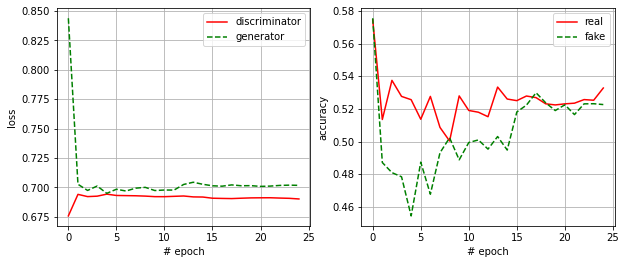

In [ ]:
display_losses_and_accuracies_gan(discriminator_loss_epoch, generator_loss_epoch, discriminator_accuracy_real_epoch, discriminator_accuracy_fake_epoch)

##### **Images generated**

This is the qualitative result of our GAN throughout training. 

We have to subsample the number of grids to show in comparison with what was generated to make it work in Colab.

Still we get the general idea that our Generator is getting quite good at forming new images. 

**You can train for more epochs, try different noise dimension, to reach better generation !**

In [ ]:
anim = get_slide_show_fake_images_in_grid(qualitative_gan_images_epoch, every_n_grid=5)
anim

## Bonus: Variational Autoencoder (VAE)

### Introduction

VAEs have been first proposed in 2014 by [Ian Goodfellow et al]()

They are autoencoders that assume the data comes from a specific type of distribution (usually Gaussian) and attempts to find this distribution.

A VAE is composed of two different Neural Networks and during training they do the following:
- The encoder learns to encode the image $x$ to retrieve the data distribution $p(z|x)$ of the latent representation $z$ following a prior distribution $q(z|x) \sim \mathcal{N}(0,1)$.
- The decoder learns to generate image $\hat{x}$ based on noise drawn from the encoder proposed data distribution. 

At inference, we will sample noise from the prior distribution, pass it through the decoder to retrieve generated images.

![](https://miro.medium.com/max/4800/1*qtXrzMLorYDl4SzKqoZxBg.png)

### Train the VAE

To train the VAE model, we will minimize the [KL divergence](https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html) between the prior and the estimated distribution:

$$L_{KL} = \mathcal{KL}\left( q(z|x) \parallel p(z|x) \right) = \mathcal{KL}\left( \mathcal{N}(\hat{\mu}, \hat{\sigma}) \parallel \mathcal{N}(0, 1) \right) = \sum_{x \in X} \left( \hat{\sigma}^2 + \hat{\mu}^2 - \log \hat{\sigma} - \frac{1}{2} \right)$$

We will also minimize the reconstruction loss between the reconstructed image and the image:

$$L_{recon} = \parallel \hat{x} - x ∥^1$$

The $L_{recon}$ loss will be implemented using the [binary cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.functional.binary_cross_entropy.html).


The final loss is:
$$L_{VAE} = L_{recon} + \beta L_{KL}$$

#### Import the used layers and classes

In [ ]:
from torch import Tensor
from torch.nn import Conv2d, ConvTranspose2d, Dropout, ReLU, Linear, Module, Sigmoid
from typing import Tuple
import torch.nn.functional as F

#### Implementation of the Encoder

The Encoder is a neural network that takes as input images of shape (1,28,28) and output $\log(\hat{\sigma})$ and $\hat{\mu}$ that parametrises the $p(z|x)$.

The architecture will be the following:
- a Convolutional layer of 32 filters of shape (3,3) and stride (2,2)
- a ReLU layer
- a Convolutional layer of 64 filters of shape (3,3) and stride (2,2)
- a ReLU layer
- a Flatten function
- a Fully-Connected layer of output size $noise\_dim * 2$

The output is then splitted in half according to the second dimension to output $\log(\hat{\sigma})$ and $\hat{\mu}$.


In [ ]:
class Encoder(Module):
  def __init__(self, noise_dim: int = 1) -> None:
    super().__init__()

    self.noise_dim = noise_dim

    # --- START CODE HERE (15)
    # Instantiate the various layers as an attribute of the Module for each layer
    self.conv_1 = Conv2d(1, 32, kernel_size=3, stride=2)
    self.relu_1 = ReLU()
    self.conv_2 = Conv2d(32, 64, kernel_size=3, stride=2)
    self.relu_2 = ReLU()
    self.fc = Linear(2304, noise_dim * 2)
    # --- END CODE HERE 
  
  def forward(self, x: Tensor) -> Tensor:
    batch_size = x.shape[0]

    # --- START CODE HERE (16)
    # Make the input x pass through all layers (do not forget the reshape)
    x = self.conv_1(x)
    x = self.relu_1(x)

    x = self.conv_2(x)
    x = self.relu_2(x)
  
    x = x.view(batch_size, -1)

    out = self.fc(x)
    # --- END CODE HERE

    mu, log_sigma = out[:, :self.noise_dim], out[:, self.noise_dim:]

    return mu, log_sigma
  
encoder = Encoder()
encoder

Encoder(
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
  (relu_1): ReLU()
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (relu_2): ReLU()
  (fc): Linear(in_features=2304, out_features=2, bias=True)
)

#### Implementation of the Decoder

The Decoder is a neural network that takes as an input a random noise of size $noise\_dim$. We will increase its dimensionality, reshape it according to a grid and use several convolutional transposed layers to upsample its resolution to reach the size of the MNIST dataset and generate an image thanks to the sigmoid activation function.

The architecture will be the following:
- a Fully-Connected layer of output size $32 \times 7 \times 7$
- a ReLU layer
- a Reshape is applied to arrange data according to a grid of shape (32, 7, 7)
- a Convolutional Transposed layer of 64 filters of shape (4,4) and stride (2,2) and padding (1,1)
- a ReLU layer
- a Convolutional Transposed layer of 32 filters of shape (4,4) and stride (2,2) and padding (1,1)
- a LeakyReLU layer with $\alpha = 0.2$
- a Convolutional layer of 1 filter of shape (3,3) and same padding
- a Sigmoid activation layer

In [ ]:
class Decoder(Module):
  def __init__(self, noise_dim: int = 1) -> None:
    """
    Create a decoder.

    Args:
      noise_dim: the dimension of the input noise.
    """

    super().__init__()

    # --- START CODE HERE (17)
    # Instantiate the various layers as an attribute of the Module for each layer
    self.fc = Linear(noise_dim, 32 * 7 * 7)
    self.relu_1 = ReLU()
    self.convt_1 = ConvTranspose2d(32, 64, kernel_size=4, stride=2, padding=1)
    self.relu_2 = ReLU()
    self.convt_2 = ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
    self.relu_3 = ReLU()
    self.conv = Conv2d(32, 1, kernel_size=3, padding="same")
    self.sig = Sigmoid()
    # --- END CODE HERE 
  
  def forward(self, x: Tensor) -> Tensor:
    # --- START CODE HERE (18)
    # Make the input x pass through all layers (do not forget the reshape)
    x = self.fc(x)
    x = self.relu_1(x)
    x = x.view(-1, 32, 7, 7)
    
    x = self.convt_1(x)
    x = self.relu_2(x)
    
    x = self.convt_2(x)
    x = self.relu_3(x)
    
    x = self.conv(x)
    
    out = self.sig(x)
    # --- END CODE HERE 

    return out

decoder = Decoder()
decoder

Decoder(
  (fc): Linear(in_features=1, out_features=1568, bias=True)
  (relu_1): ReLU()
  (convt_1): ConvTranspose2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu_2): ReLU()
  (convt_2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu_3): ReLU()
  (conv): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (sig): Sigmoid()
)

#### Implementation of the VAE model

We will define a VAE wrapper that takes as an input both the encoder and the decoder.

The input of the VAE model will be an image and the pipeline is:
- Pass the image through the encoder to retrieve $\log(\hat{\sigma})$ and $\hat{\mu}$.
- Sample $z \sim \mathcal{N}(\hat{\mu}, \hat{\sigma})$.
- Pass $z$ through the decoder.
- Return the losses.

In [ ]:
class VAE(Module):
  def __init__(self, encoder: Module, decoder: Module) -> None:
    """
    Create a VAE.

    Args:
      encoder: the encoder.
      decoder: the decoder.
    """
    super().__init__()

    self.encoder = encoder
    self.decoder = decoder
  
  def sampling(self, mu, log_sigma):
      std = torch.exp(0.5 * log_sigma)
      eps = torch.randn_like(std)
      return eps.mul(std).add_(mu)
  
  def loss_kl(self, mu, log_sigma):
    # --- START CODE HERE (19)
    # Write the kl loss.
    kl_loss = -0.5 * torch.sum(1 + log_sigma - mu.pow(2) -   log_sigma.exp())
    # --- END CODE HERE 
    return kl_loss
  
  def loss_reconstruction(self, recon_x, x):
    # --- START CODE HERE (20)
    # Write the reconstruction loss.
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    # --- END CODE HERE 
    return recon_loss

  def forward(self, x: Tensor) -> Tuple[Tensor]:
    # --- START CODE HERE (21)
    # Implement the forward pass for the VAE by using the encoder, decoder, and the functions define above.
    mu, log_sigma = self.encoder(x)
    z = self.sampling(mu, log_sigma)
    recon_x = self.decoder(z)
    kl_loss = self.loss_kl(mu, log_sigma)
    recon_loss = self.loss_reconstruction(recon_x, x)
    # --- END CODE HERE 

    return kl_loss, recon_loss
  
  def generate_image(self, x: Tensor) -> Tensor:
    return self.decoder(x)

vae = VAE(encoder, decoder)
vae

VAE(
  (encoder): Encoder(
    (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (relu_1): ReLU()
    (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (relu_2): ReLU()
    (fc): Linear(in_features=2304, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=1, out_features=1568, bias=True)
    (relu_1): ReLU()
    (convt_1): ConvTranspose2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (relu_2): ReLU()
    (convt_2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (relu_3): ReLU()
    (conv): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (sig): Sigmoid()
  )
)

#### Make the training loop

In the training loop, we will iterate over the provided dataloader for several epochs and perform:
- Update of the VAE parameters
- Data Generation

We will add the losses outputed by the VAE model to compute:
$$L_{VAE} = L_{recon} + \beta L_{KL}$$

Aswell as displaying metrics, we will also display qualitative result which is the images generated throughout training.

In [ ]:
from torch.utils.data import DataLoader
from torch.optim import Optimizer
from typing import Tuple, Any
import time


def training_loop_vae(
  dataloader: DataLoader, 
  vae: Module, 
  vae_optimizer: Optimizer,
  beta: float = 1.,
  n_epochs: int = 20,
  noise_dim: int = 100,
  n_images_qualitative: int = 25,
  device: str = "cpu"
) -> Tuple[Any]:
  """
  Perform the training_loop for the GAN model.

  Args:
    dataloader: the dataloader over the training data.
    vae: the vae model.
    vae_optimizer: the optimizer to optimize the vae parameters.
    beta: the loss coefficient for the KL divergence.
    n_epochs: the number of epochs to perform.
    n_images_qualitative: the number of images to generate per epoch for qualitative results.
    device: the device to make computations on.
  
  Returns:
    Tuple of:
      - list of kl vae loss per epoch.
      - list of reconstruction vae loss per epoch.
      - list of qualitative images generated per epoch.
  """

  kl_loss_epoch = []
  recon_loss_epoch = []
  qualitative_images_epoch = []

  start_time = time.time()

  # Random noise used for visualization at each epoch
  random_noise = torch.randn(n_images_qualitative, noise_dim, device=device) 

  for num_epoch in range(n_epochs):
    kl_loss_iter = []
    recon_loss_iter = []

    vae.train()
    for idx, batch in enumerate(dataloader):
      real_data, _ = batch

      if device == "cuda":
        real_data = real_data.cuda(non_blocking=True)

      n_samples = real_data.shape[0]


      # --- START CODE HERE (22)
      # Here you need to make the optimization step of your vae.
      # The loss is defined by the sum of the kl multiplied by beta and
      # the reconstruction

      vae_optimizer.zero_grad()

      kl_loss, recon_loss = vae(real_data)

      loss = beta * kl_loss + recon_loss

      loss.backward()

      vae_optimizer.step()
      # --- END CODE HERE

      kl_loss_iter.append(kl_loss.item())
      recon_loss_iter.append(recon_loss.item())
    
    kl_loss_epoch.append(torch.mean(torch.tensor(kl_loss_iter)))
    recon_loss_epoch.append(torch.mean(torch.tensor(recon_loss_iter)))
    
    # Image generator for visualization at each epoch
    with torch.no_grad():
      vae.eval()
      qualitative_images = vae.generate_image(random_noise)
      qualitative_images_epoch.append(qualitative_images)

    print("epoch: {0:d} in {1:04d} seconds (loss: kl {2:.4f} recon {3:.4f})".format(num_epoch, int(time.time()-start_time), kl_loss_epoch[-1], recon_loss_epoch[-1]))
  
  return kl_loss_epoch, recon_loss_epoch, qualitative_images_epoch


#### Perform the training of the model

Now that everything is implemented, we can actually perform the training of our GAN.

We need to instantiate the various models on the right device and to [apply](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.apply) the initialization of their weights.

We will use the optimizer ADAM for both networks with the following parameters:
- $lr = 0.0001$

In [ ]:
import torch.backends.cudnn as cudnn
import random

from torch.optim import Adam
cudnn.benchmark = True

#set manual seed to a constant get a consistent output
manualSeed = 4017
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

#Define the hyper-parameters to train.
n_epochs = 25
noise_dim = 2
beta = 1.
n_images_qualitative = 25
device = "cuda" if torch.cuda.is_available() else "cpu"

dataloader = DataLoader(dataset_train, shuffle=True, batch_size=128, drop_last=True, num_workers=2)

# --- START CODE HERE (23)
# Instantiate the models and optimizers
encoder = Encoder(noise_dim=noise_dim)
decoder = Decoder(noise_dim=noise_dim)
vae = VAE(encoder, decoder)
vae = vae.to(device)
vae.apply(weights_init)

vae_optimizer = Adam(vae.parameters(), lr=1e-4)
# --- END CODE HERE

kl_loss_epoch, recon_loss_epoch, qualitative_vae_images_epoch =\
  training_loop_vae(dataloader, vae, vae_optimizer, beta, n_epochs, noise_dim, n_images_qualitative, device)


Random Seed:  4017
epoch: 0 in 0007 seconds (loss: kl 721.5385 recon 35835.2969)
epoch: 1 in 0014 seconds (loss: kl 659.9352 recon 24391.4336)
epoch: 2 in 0021 seconds (loss: kl 667.9136 recon 22569.2871)
epoch: 3 in 0028 seconds (loss: kl 668.6666 recon 21987.4062)
epoch: 4 in 0035 seconds (loss: kl 671.5037 recon 21654.3203)
epoch: 5 in 0043 seconds (loss: kl 673.6736 recon 21418.5957)
epoch: 6 in 0050 seconds (loss: kl 674.8747 recon 21236.8008)
epoch: 7 in 0057 seconds (loss: kl 677.7841 recon 21087.8086)
epoch: 8 in 0064 seconds (loss: kl 678.5893 recon 20968.9688)
epoch: 9 in 0071 seconds (loss: kl 681.1148 recon 20857.9961)
epoch: 10 in 0078 seconds (loss: kl 683.0709 recon 20768.4395)
epoch: 11 in 0085 seconds (loss: kl 685.8994 recon 20684.9277)
epoch: 12 in 0092 seconds (loss: kl 686.4872 recon 20606.9258)
epoch: 13 in 0099 seconds (loss: kl 691.8780 recon 20532.4707)
epoch: 14 in 0106 seconds (loss: kl 697.0547 recon 20451.0605)
epoch: 15 in 0114 seconds (loss: kl 701.0719 r

#### Visualize your results

##### **Losses**

You should observe that the reconstruction loss diminuish. The KL loss depending on the $\beta$ coefficient have different behavior and can either:
- decrease.
- increase.
- decrease then increase.


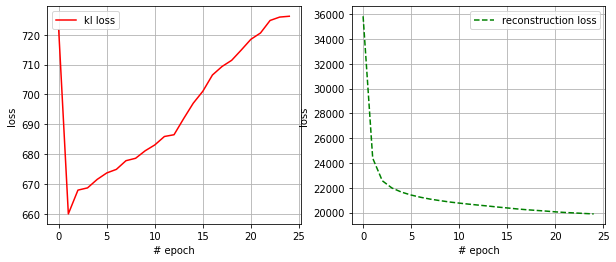

In [ ]:
display_losses_and_accuracies_vae(kl_loss_epoch, recon_loss_epoch)

##### **Images generated**

This is the qualitative result of our VAE throughout training. 

We have to subsample the number of grids to show in comparison with what was generated to make it work in Colab.

Still we get the general idea that our VAE is getting quite good at forming new images. 

**You can train for more epochs, try different $\beta$ coefficients and dimension for the noise, to reach better generation !**

In [ ]:
anim = get_slide_show_fake_images_in_grid(qualitative_vae_images_epoch, every_n_grid=5)
anim